In [169]:
import os
import re
import cv2
import sys
import glob
import pandas as pd
import numpy as np
sys.path.append("../table/")
sys.path.append("../")
sys.path.append("../stripes/")

import table
import neighbours
from stripes.palette import targets_dict

import matplotlib.pyplot as plt
%matplotlib inline

In [170]:
def read_image_with_number(image_name):
    """.../12/IMG_33341001.png -> (image, 12)"""
    assert os.path.isfile(image_name), "File not found"
#     number = re.findall("/[0-9]{1,2}/", image_name)
    number = re.findall("/[0-9]{1,2}.jpg", image_name)

    assert len(number) > 0, "Invalid filename"
#     number = number[0][1:-1]
    number = number[0][1:-4]
    
    image = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    return image, int(number)

In [171]:
data = pd.read_csv("../../images/stripe experiments/compact/table_compact.csv", sep=',')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,N,GLU,BIL,KET,SG,BLO,PH,PRO,URO,NIT,LEU
0,0.png,100,1,80,1.020,-1,7.5,0,2.0,0,1
1,1.png,1000,2,40,1.030,4,6.0,3,4.0,1,3
2,2.png,500,-1,80,1.030,4,7.5,4,0.2,1,1
3,3.png,250,1,15,1.025,4,8.5,2,0.2,1,0
4,4.png,250,3,160,1.015,3,5.0,-1,4.0,1,3


In [172]:
import pickle as pkl
with open("compact_table_geometry.pkl", "rb") as f:
    table_geometry = pkl.load(f)
tabler = table.Table(**table_geometry)

In [173]:
import colormath.color_objects as co
import colormath.color_diff as cd


In [174]:
def preprocessing_crop(img1):
    img1 = cv2.medianBlur(img1,3)
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2LAB)

    qwidth1, qheight1 = img1.shape[1] / 1.7, img1.shape[0] / 1.7
    lmargin1 = (img1.shape[1] - qwidth1) / 2
    rmargin1 = img1.shape[1] - lmargin1
    tmargin1 = (img1.shape[0] - qheight1) / 2
    bmargin1 = img1.shape[0] - tmargin1
        
    crop1 = img1[int(tmargin1): int(bmargin1), int(lmargin1): int(rmargin1), :]
    
    return crop1

def get_weighted_manhattan_distance(img1,img2):
    """
    Current state:
    calculate mean values of channels of images img1, img2:
    and then calculate manhattan distance with weights over them.
    weights = [1,5,4] were chosen using grid search 
    (! both images should be in LAB color space !)
    
    Takes as input:
    
    - img1, img2 - numpy 3d arrays 
    
    Returns:
    
    - distance - float, distance between two input images
    """
    weights = [2.,5.,3.]
    
    point1 = np.mean(img1,axis=(0,1))
    point2 = np.mean(img2,axis=(0,1))
    
    d = 0.
    
    for i in xrange(point1.shape[0]):
        d += weights[i]*np.abs(point1[i] - point2[i])
        
    return d

def get_ciede(img1,img2):
    L1,a1,b1 = np.mean(img1,axis=(0,1))
    L2,a2,b2 = np.mean(img2,axis=(0,1))
    
    p1 = co.LabColor(L1,a1,b1)
    p2 = co.LabColor(L2,a2,b2)
    
    return cd.delta_e_cie2000(p1,p2)

In [175]:
from collections import defaultdict

Successful fit of ../../images/stripe experiments/tests/stable_color/6.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


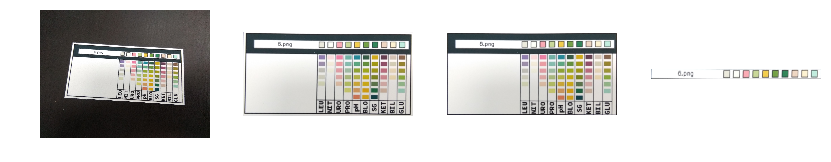

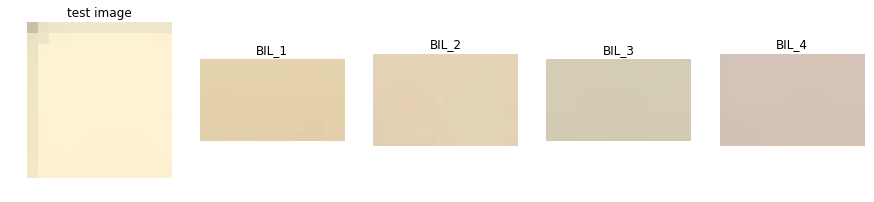

true label: 2, predicted label: 2


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


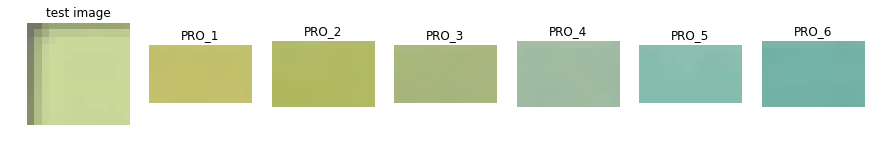

true label: 3, predicted label: 3


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


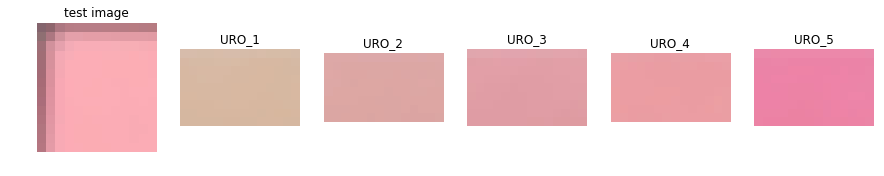

true label: 4, predicted label: 4


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


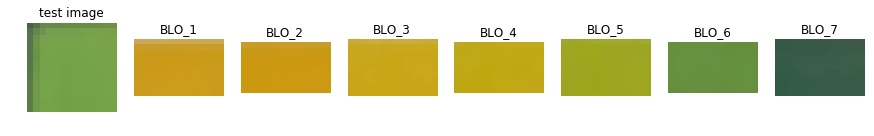

true label: 6, predicted label: 6


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


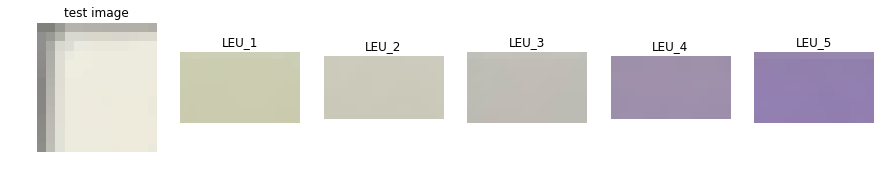

true label: 2, predicted label: 2


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


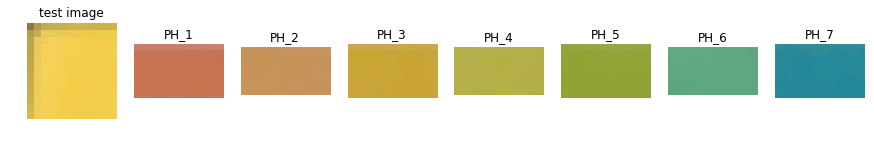

true label: 3, predicted label: 3


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


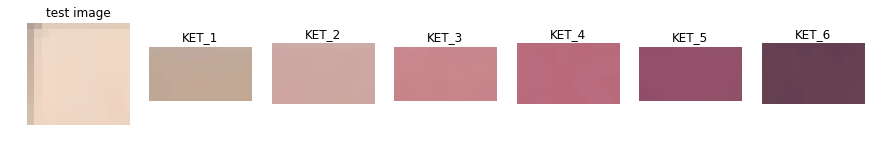

true label: 1, predicted label: 1


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


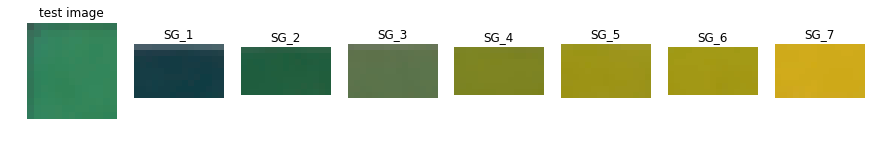

true label: 2, predicted label: 2


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


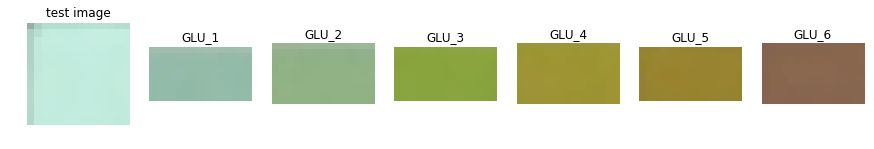

true label: 1, predicted label: 1


NIT ['NIT_1', 'NIT_3', 'NIT_2']


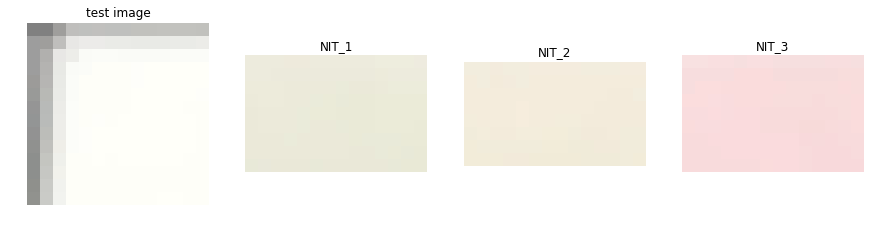

true label: 1, predicted label: 2


Successful fit of ../../images/stripe experiments/tests/stable_color/5.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


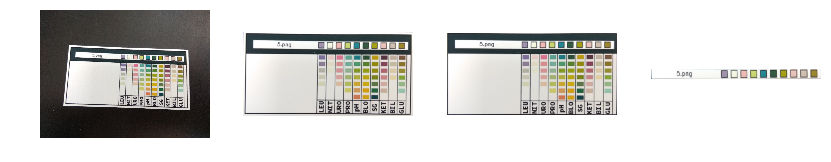

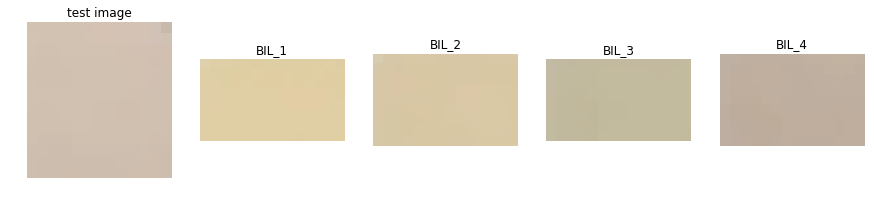

true label: 4, predicted label: 4


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


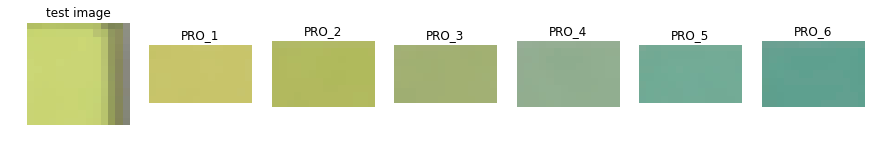

true label: 2, predicted label: 2


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


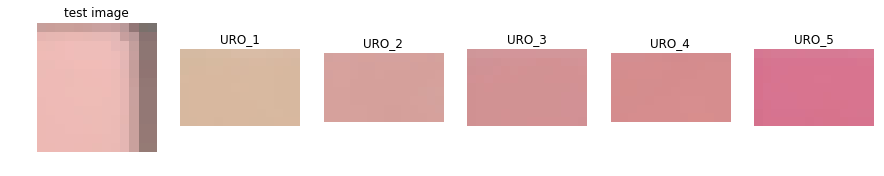

true label: 2, predicted label: 2


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


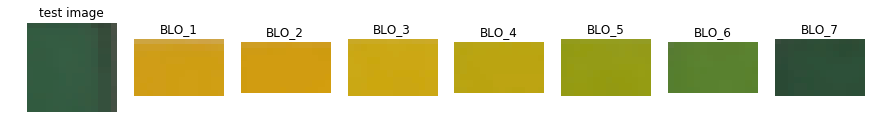

true label: 7, predicted label: 7


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


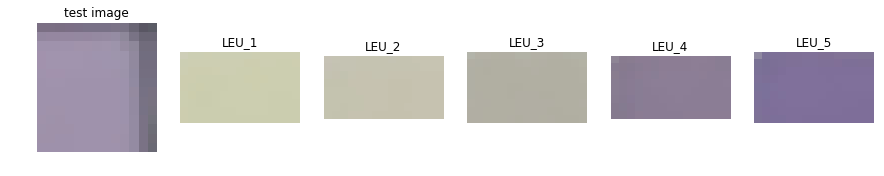

true label: 4, predicted label: 4


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


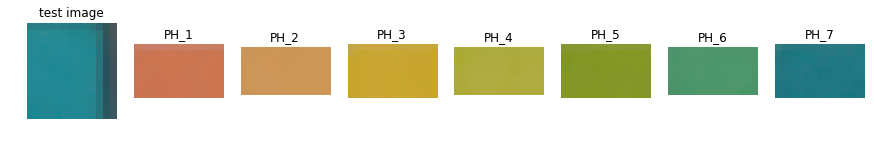

true label: 7, predicted label: 7


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


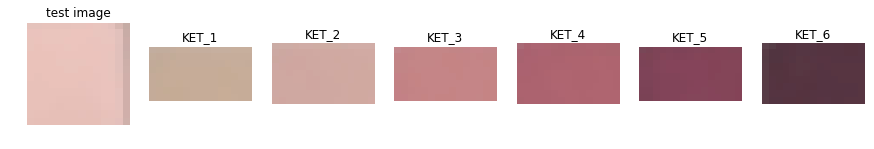

true label: 2, predicted label: 2


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


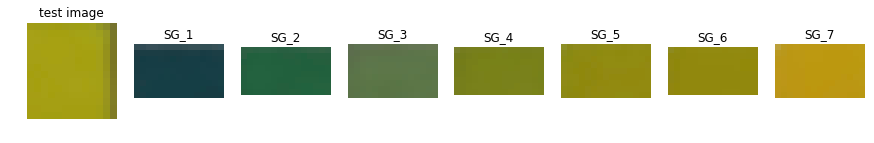

true label: 5, predicted label: 5


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


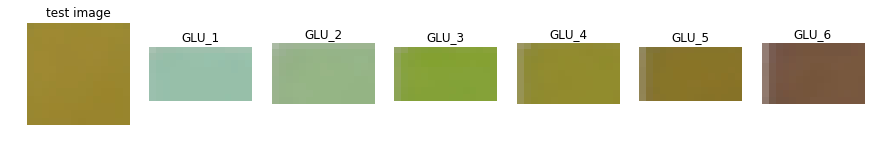

true label: 5, predicted label: 4


NIT ['NIT_1', 'NIT_3', 'NIT_2']


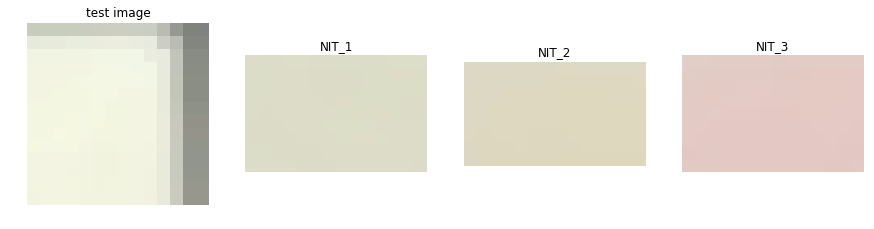

true label: 1, predicted label: 1


Successful fit of ../../images/stripe experiments/tests/stable_color/4.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


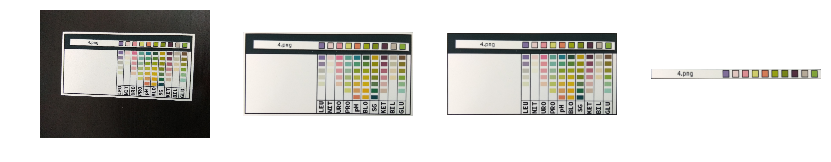

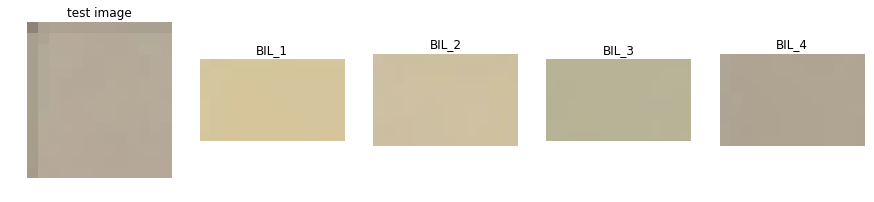

true label: 4, predicted label: 4


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


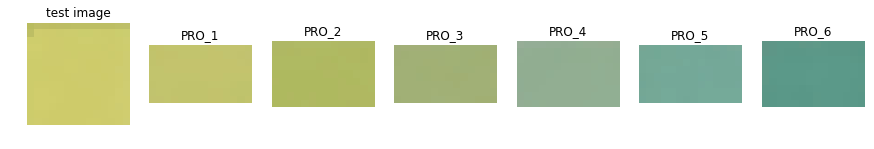

true label: 1, predicted label: 1


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


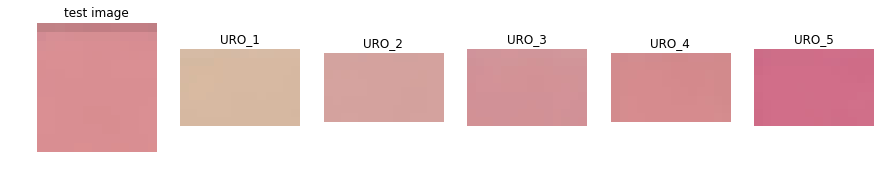

true label: 4, predicted label: 4


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


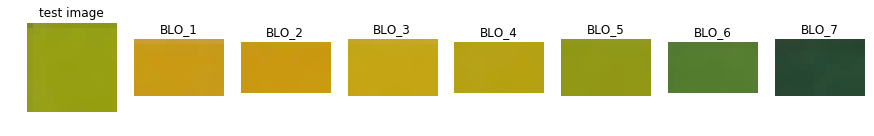

true label: 5, predicted label: 5


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


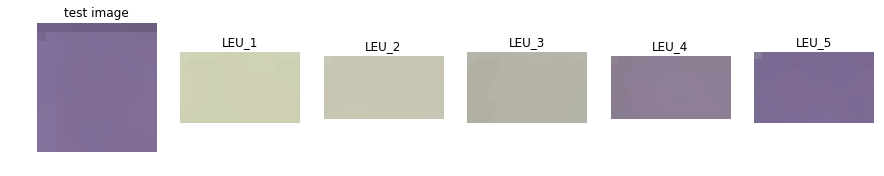

true label: 5, predicted label: 5


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


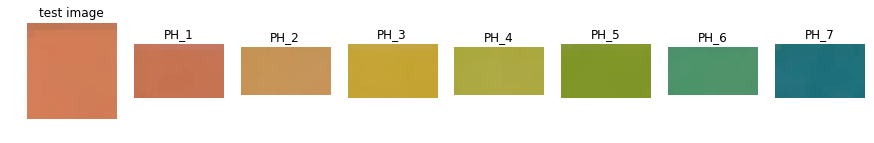

true label: 1, predicted label: 1


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


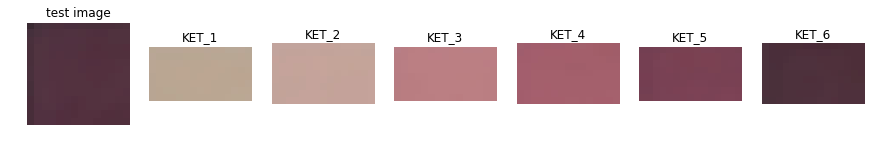

true label: 6, predicted label: 6


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


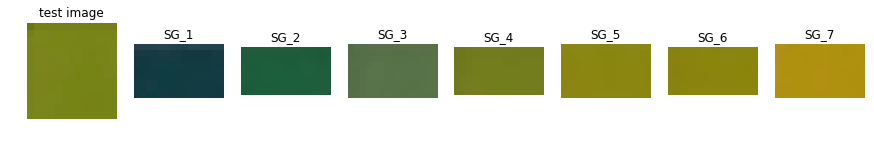

true label: 4, predicted label: 4


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


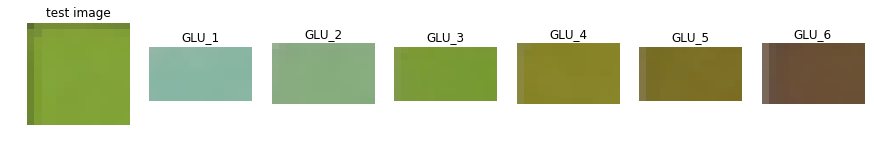

true label: 3, predicted label: 3


NIT ['NIT_1', 'NIT_3', 'NIT_2']


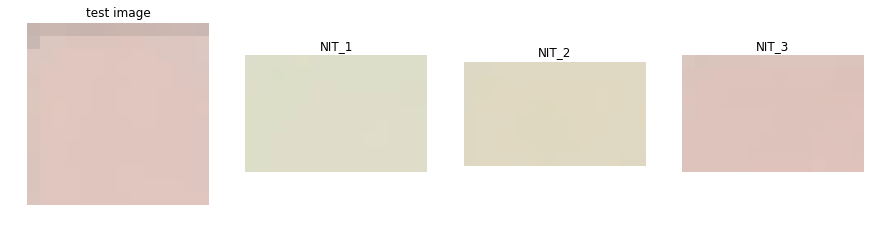

true label: 3, predicted label: 3


Successful fit of ../../images/stripe experiments/tests/stable_color/11.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


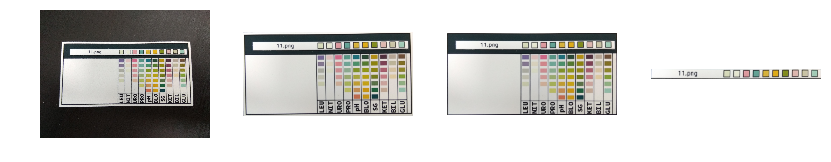

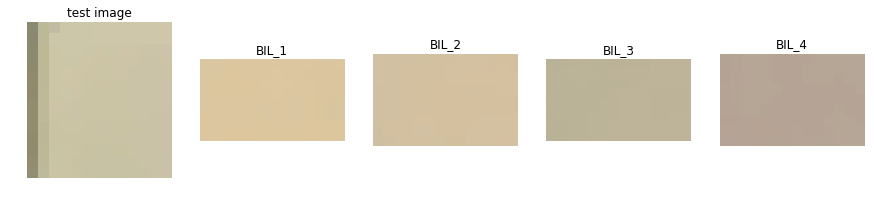

true label: 3, predicted label: 3


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


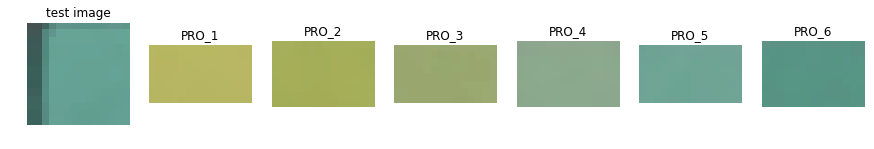

true label: 6, predicted label: 6


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


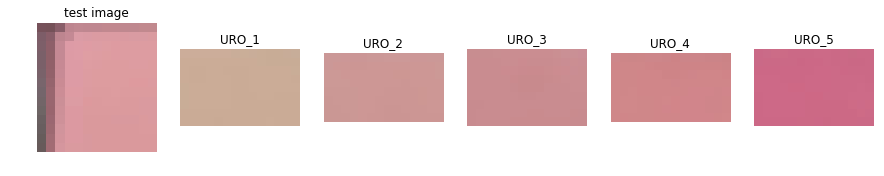

true label: 3, predicted label: 3


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


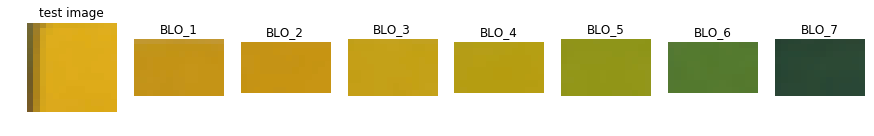

true label: 1, predicted label: 3


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


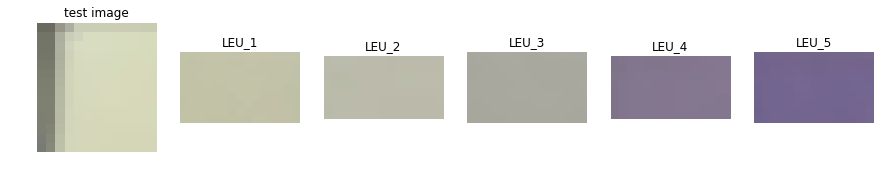

true label: 1, predicted label: 1


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


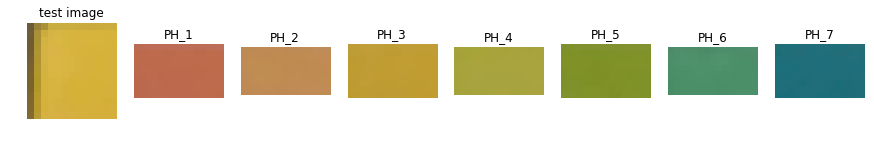

true label: 3, predicted label: 3


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


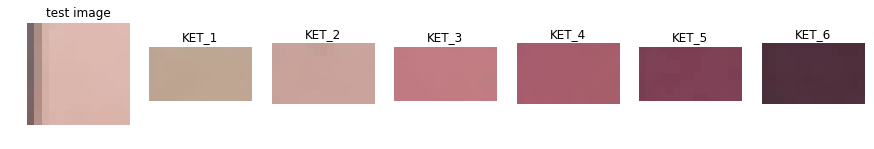

true label: 2, predicted label: 2


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


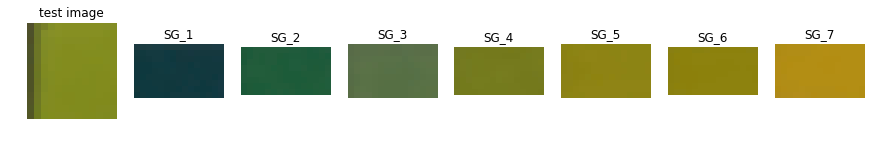

true label: 4, predicted label: 4


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


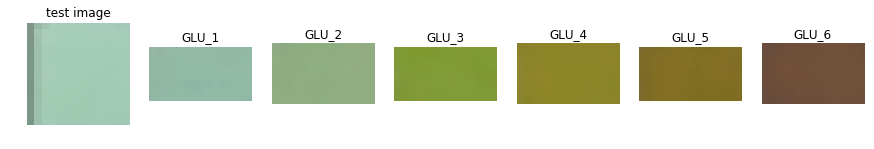

true label: 1, predicted label: 1


NIT ['NIT_1', 'NIT_3', 'NIT_2']


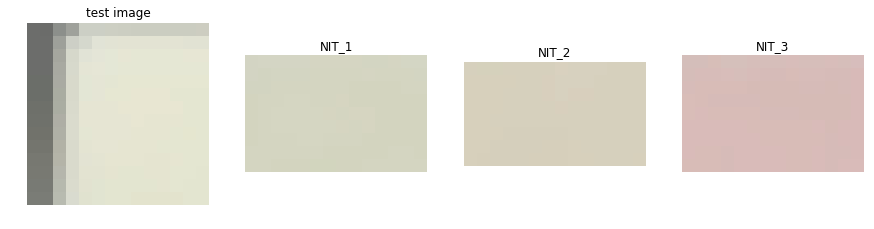

true label: 1, predicted label: 1


Successful fit of ../../images/stripe experiments/tests/stable_color/0.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


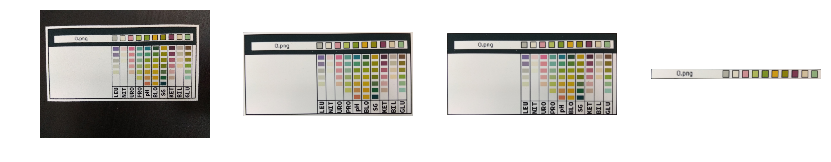

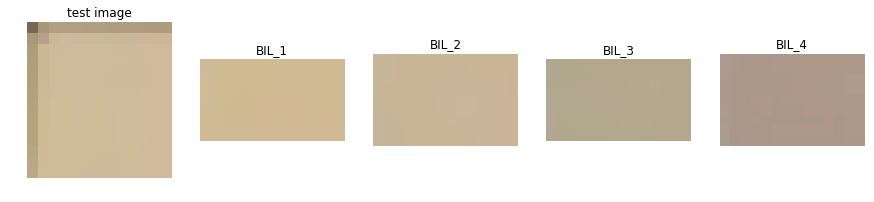

true label: 2, predicted label: 2


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


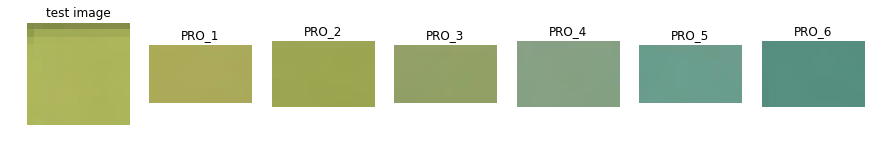

true label: 2, predicted label: 2


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


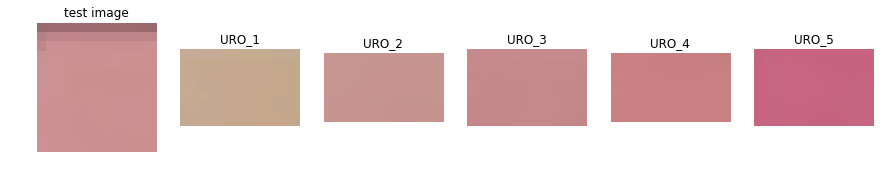

true label: 3, predicted label: 3


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


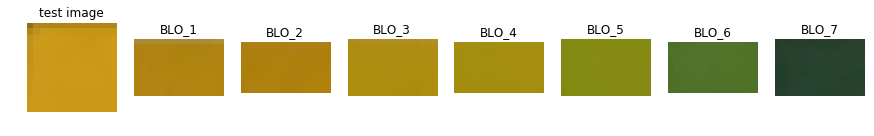

true label: 1, predicted label: 1


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


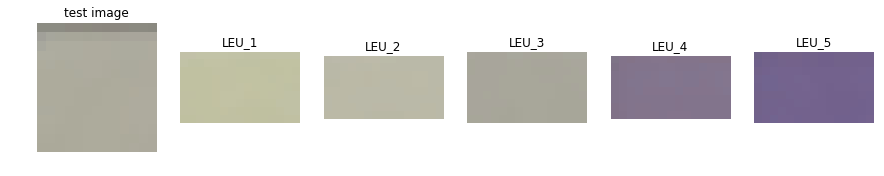

true label: 3, predicted label: 3


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


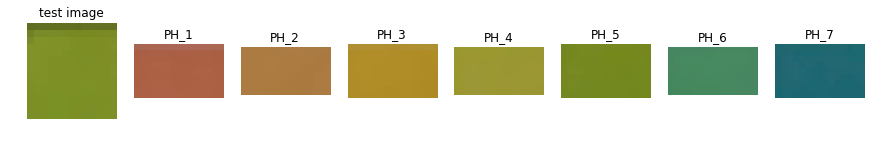

true label: 5, predicted label: 5


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


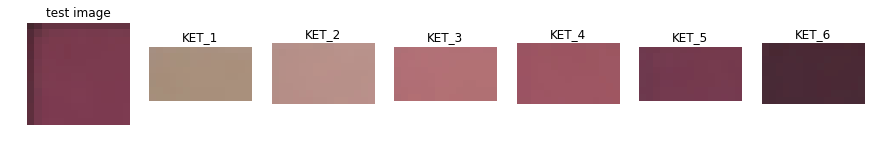

true label: 5, predicted label: 5


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


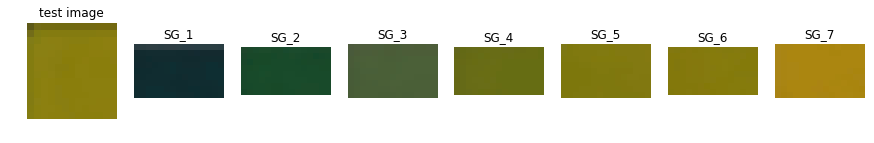

true label: 5, predicted label: 6


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


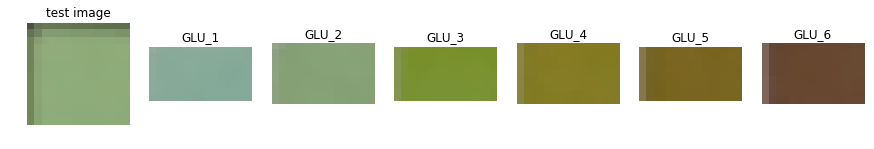

true label: 2, predicted label: 2


NIT ['NIT_1', 'NIT_3', 'NIT_2']


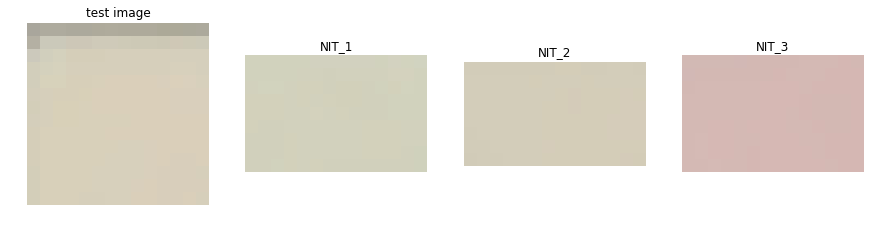

true label: 2, predicted label: 2


Successful fit of ../../images/stripe experiments/tests/stable_color/7.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


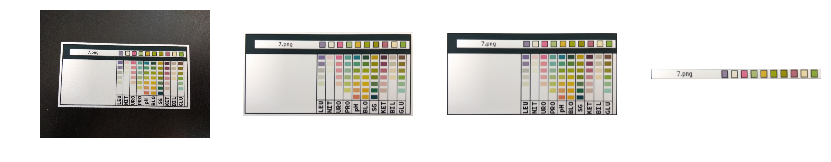

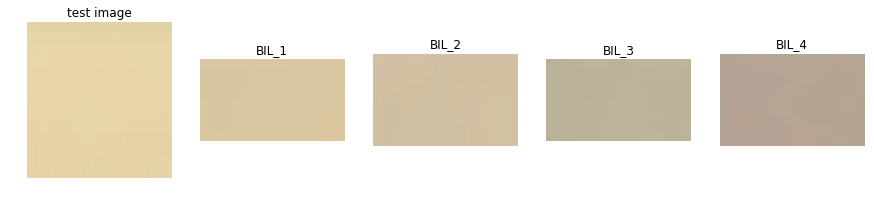

true label: 1, predicted label: 1


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


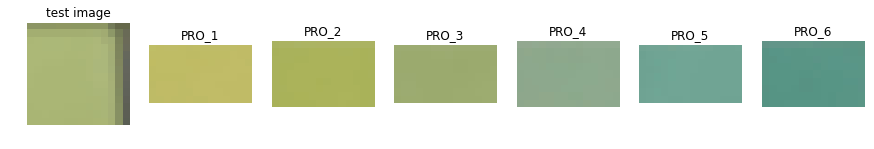

true label: 3, predicted label: 3


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


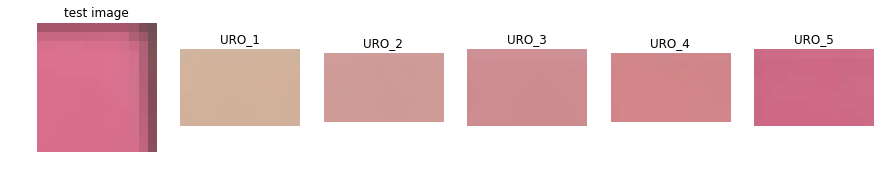

true label: 5, predicted label: 5


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


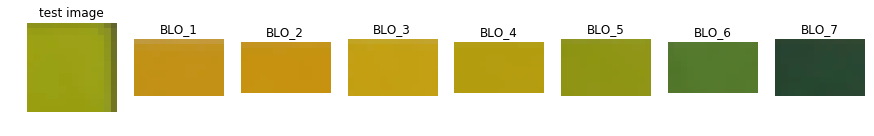

true label: 5, predicted label: 5


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


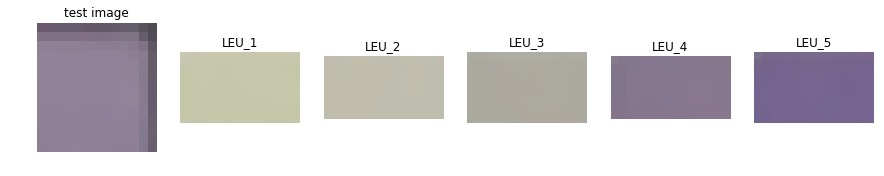

true label: 4, predicted label: 4


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


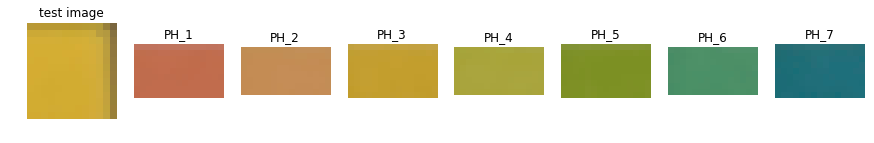

true label: 3, predicted label: 3


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


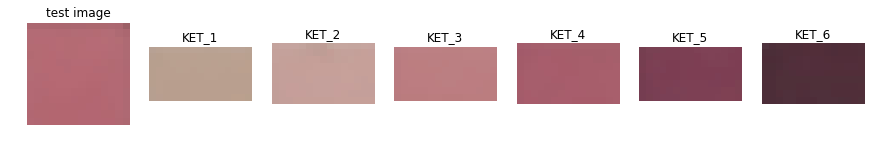

true label: 4, predicted label: 4


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


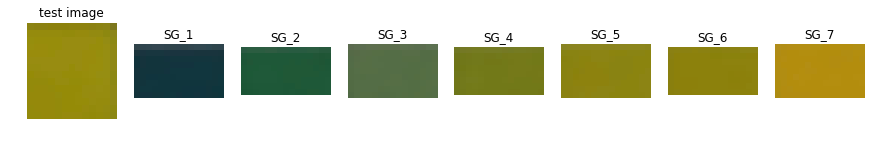

true label: 6, predicted label: 5


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


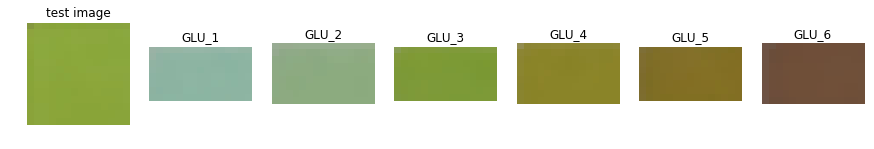

true label: 3, predicted label: 3


NIT ['NIT_1', 'NIT_3', 'NIT_2']


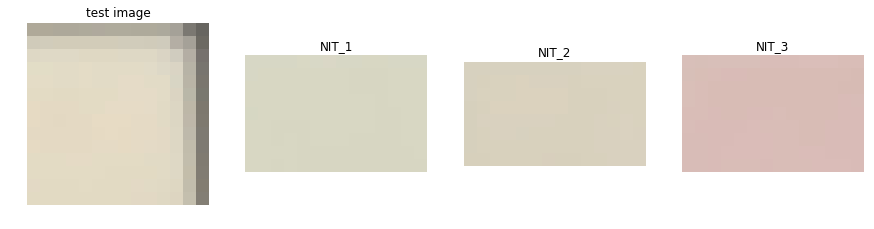

true label: 2, predicted label: 2


Successful fit of ../../images/stripe experiments/tests/stable_color/12.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


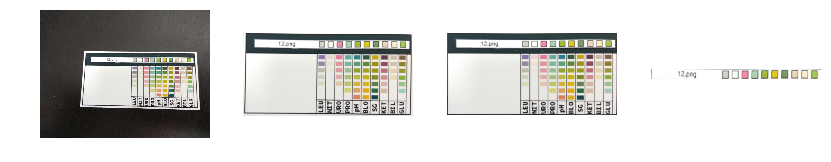

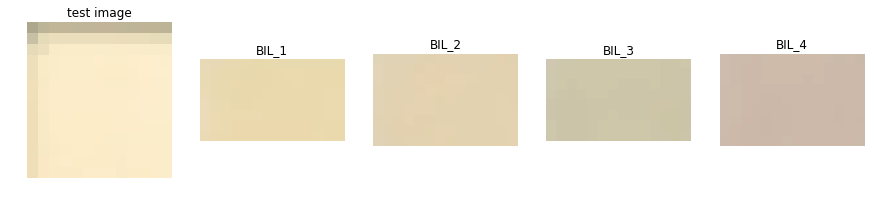

true label: 2, predicted label: 1


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


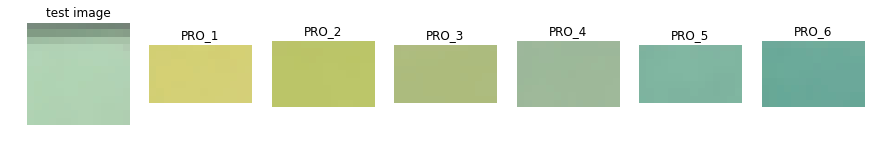

true label: 4, predicted label: 4


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


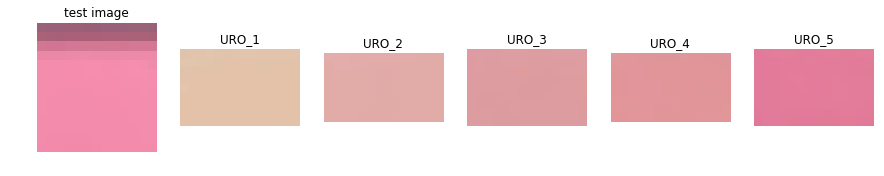

true label: 5, predicted label: 5


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


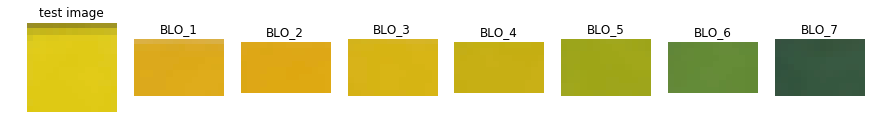

true label: 4, predicted label: 4


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


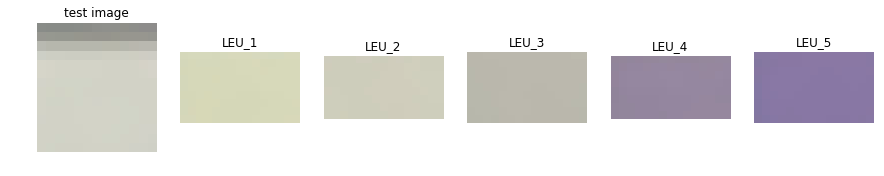

true label: 3, predicted label: 2


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


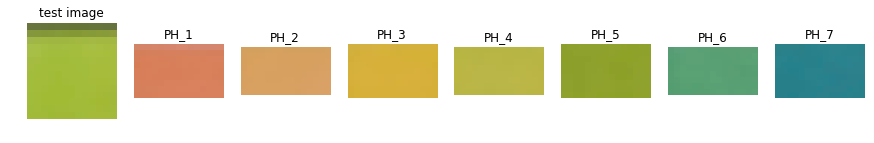

true label: 5, predicted label: 5


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


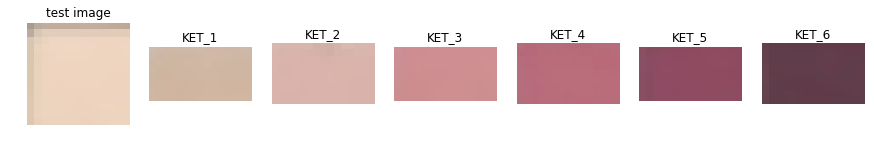

true label: 1, predicted label: 1


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


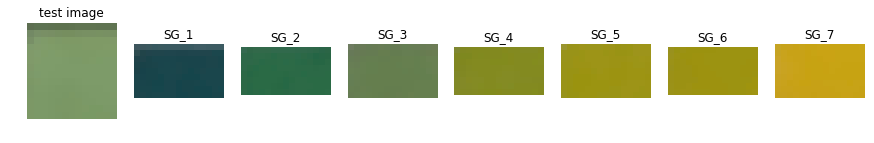

true label: 3, predicted label: 3


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


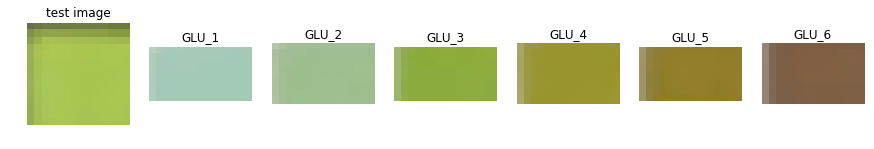

true label: 3, predicted label: 3


NIT ['NIT_1', 'NIT_3', 'NIT_2']


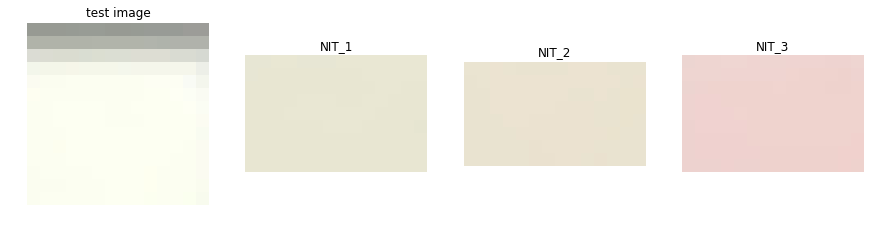

true label: 1, predicted label: 1


Successful fit of ../../images/stripe experiments/tests/stable_color/10.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


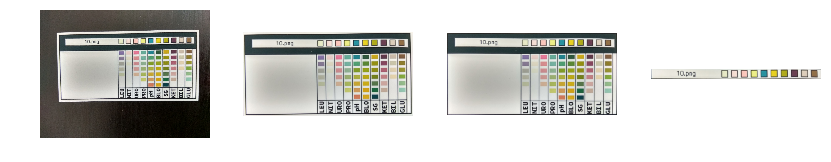

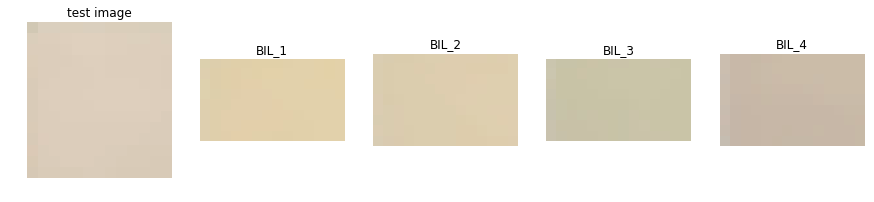

true label: 4, predicted label: 2


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


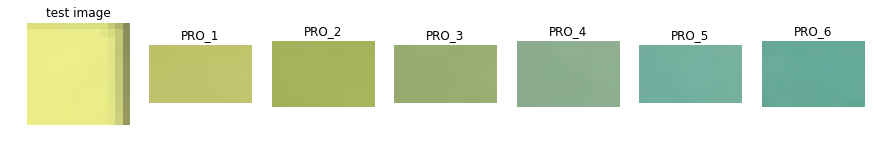

true label: 1, predicted label: 1


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


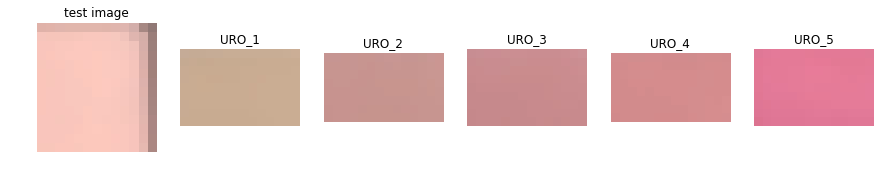

true label: 2, predicted label: 2


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


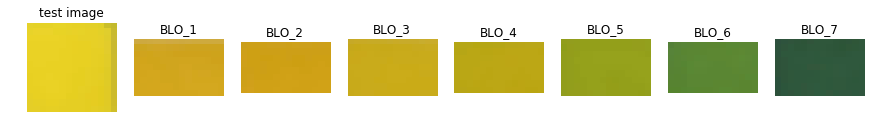

true label: 4, predicted label: 4


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


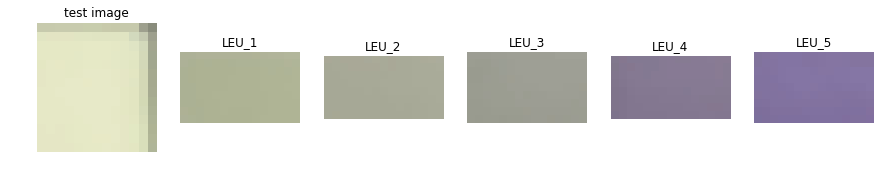

true label: 1, predicted label: 1


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


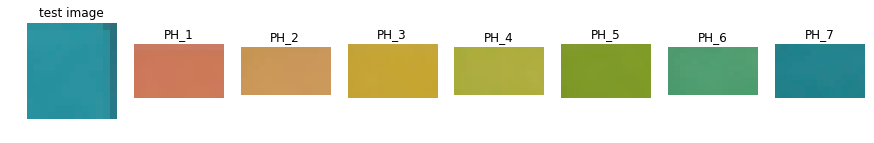

true label: 7, predicted label: 7


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


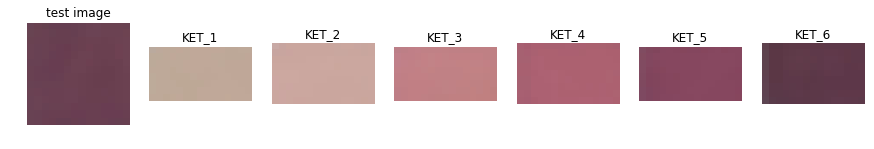

true label: 6, predicted label: 6


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


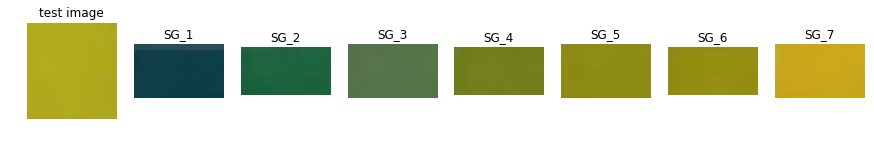

true label: 5, predicted label: 7


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


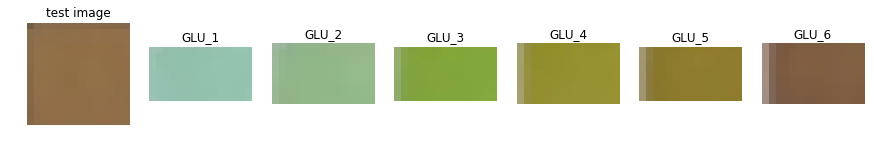

true label: 6, predicted label: 6


NIT ['NIT_1', 'NIT_3', 'NIT_2']


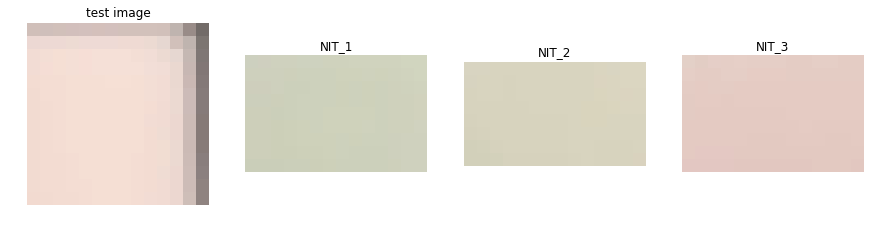

true label: 3, predicted label: 3


Successful fit of ../../images/stripe experiments/tests/stable_color/9.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


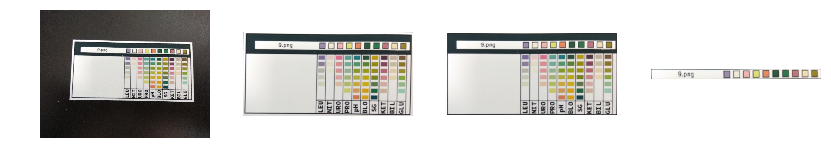

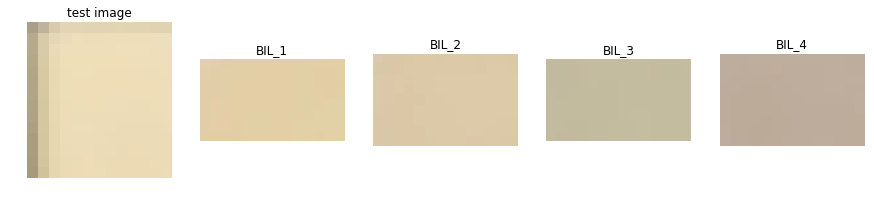

true label: 2, predicted label: 1


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


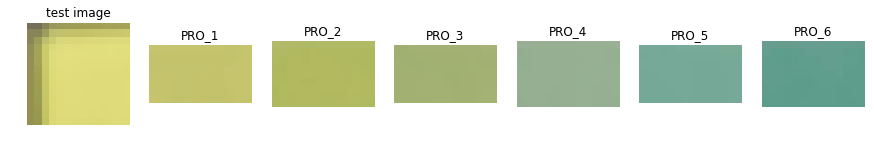

true label: 1, predicted label: 1


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


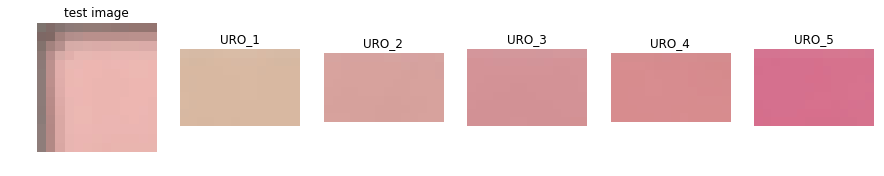

true label: 2, predicted label: 2


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


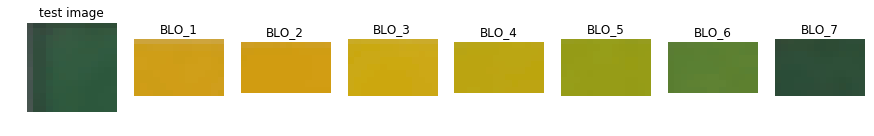

true label: 7, predicted label: 7


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


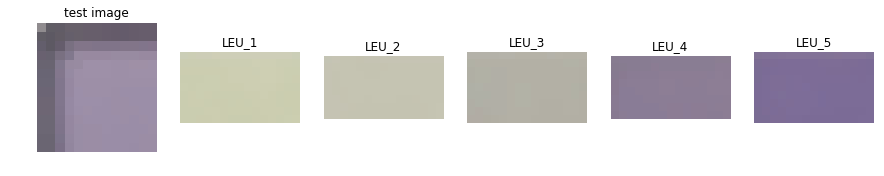

true label: 4, predicted label: 4


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


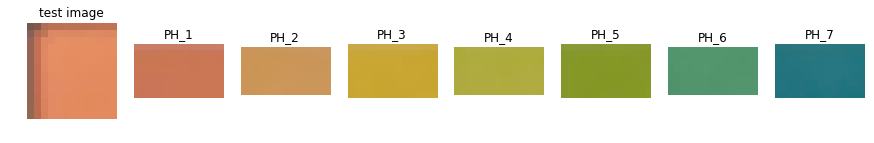

true label: 1, predicted label: 1


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


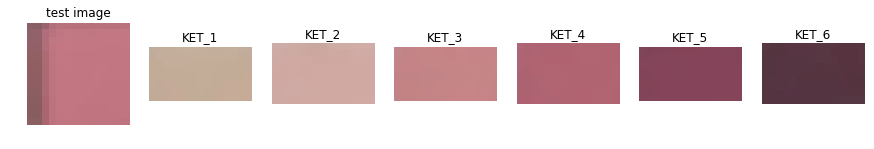

true label: 4, predicted label: 4


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


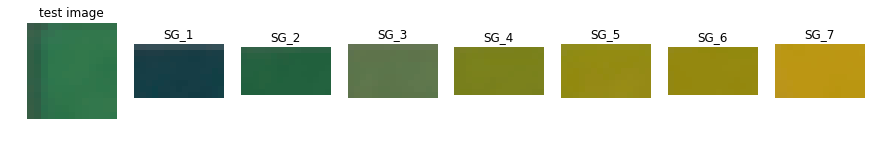

true label: 2, predicted label: 2


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


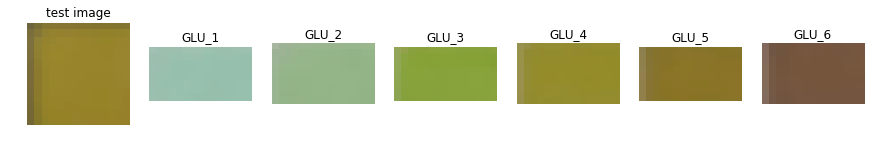

true label: 5, predicted label: 5


NIT ['NIT_1', 'NIT_3', 'NIT_2']


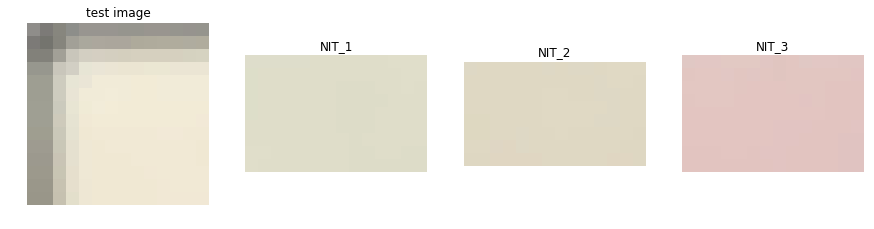

true label: 2, predicted label: 2


Successful fit of ../../images/stripe experiments/tests/stable_color/3.jpg
BIL ['BIL_1', 'BIL_3', 'BIL_2', 'BIL_4']


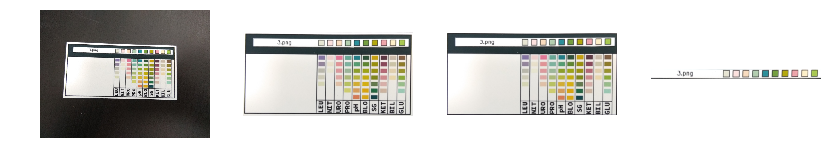

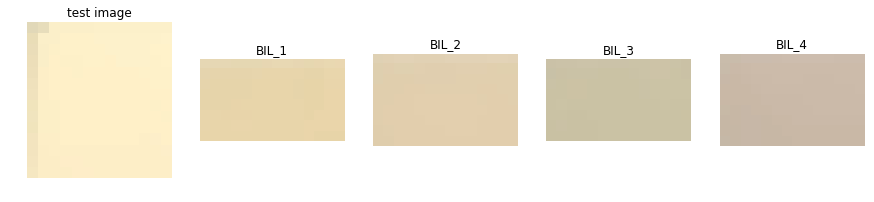

true label: 2, predicted label: 1


PRO ['PRO_1', 'PRO_3', 'PRO_2', 'PRO_5', 'PRO_4', 'PRO_6']


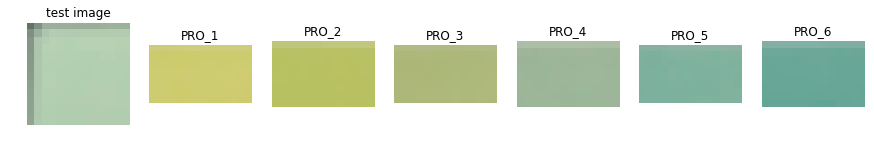

true label: 4, predicted label: 4


URO ['URO_1', 'URO_2', 'URO_3', 'URO_4', 'URO_5']


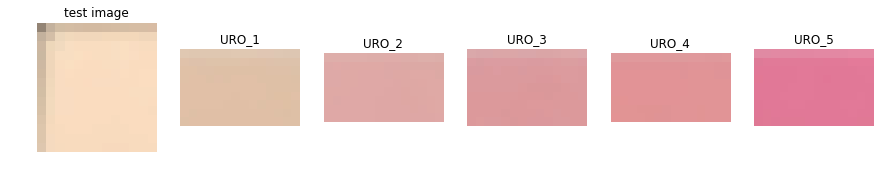

true label: 1, predicted label: 1


BLO ['BLO_1', 'BLO_3', 'BLO_2', 'BLO_5', 'BLO_4', 'BLO_7', 'BLO_6']


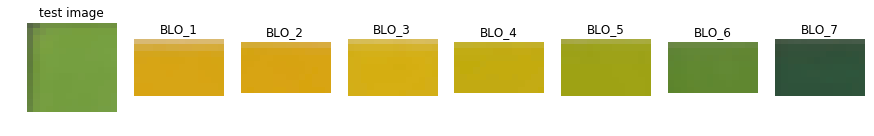

true label: 6, predicted label: 6


LEU ['LEU_2', 'LEU_3', 'LEU_1', 'LEU_4', 'LEU_5']


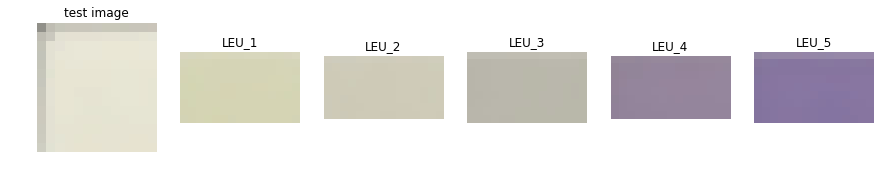

true label: 2, predicted label: 2


PH ['PH_1', 'PH_3', 'PH_2', 'PH_5', 'PH_4', 'PH_7', 'PH_6']


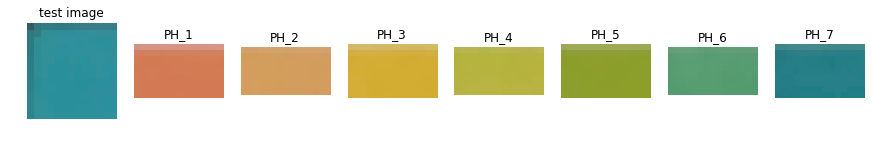

true label: 7, predicted label: 7


KET ['KET_1', 'KET_2', 'KET_3', 'KET_4', 'KET_5', 'KET_6']


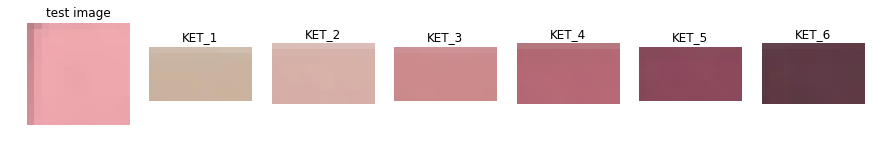

true label: 3, predicted label: 3


SG ['SG_3', 'SG_2', 'SG_1', 'SG_7', 'SG_6', 'SG_5', 'SG_4']


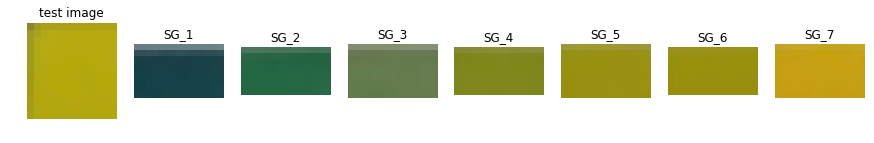

true label: 6, predicted label: 7


GLU ['GLU_2', 'GLU_3', 'GLU_1', 'GLU_6', 'GLU_4', 'GLU_5']


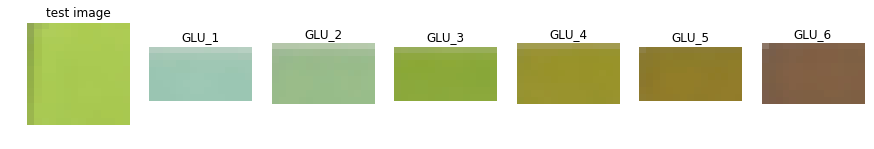

true label: 3, predicted label: 3


NIT ['NIT_1', 'NIT_3', 'NIT_2']


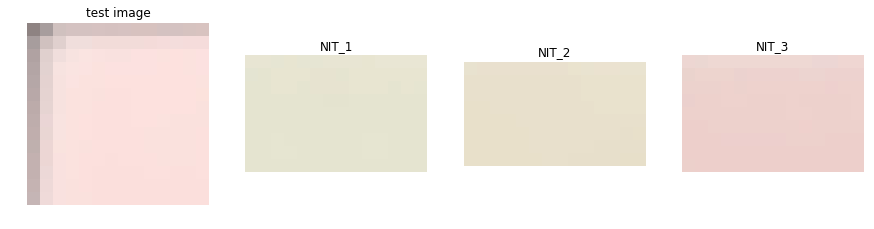

true label: 3, predicted label: 3




In [176]:
results_soft = defaultdict(list)
results_hard = defaultdict(list)
results = []

# for image_name in glob.glob("../../images/stripe experiments/tests/0/*.*"):
for image_name in glob.glob("../../images/stripe experiments/tests/stable_color/*.jpg"):
#     print image_name
    image, number = read_image_with_number(image_name)
    result = {"name" : number}
    try:
       
        tabler.fit(image)
        plt.figure(figsize=(14,6))
        plt.subplot(1,4,1)
        plt.axis('off')
        plt.imshow(image)
        plt.subplot(1,4,2)
        plt.axis('off')
        plt.imshow(tabler.template)
        plt.subplot(1,4,3)
        plt.axis('off')
        plt.imshow(tabler.roi)
        plt.subplot(1,4,4)
        plt.axis('off')
        plt.imshow(tabler.strip)
        
        palette = tabler.palette
        colorbar = tabler.colorbar
        print "Successful fit of {}".format(image_name)
        
    except ValueError:
        print "Unsuccessful fit of {}".format(image_name)
        continue
    for key_test, image_test in colorbar.iteritems():
        train = {}
        for key_train, image_train in palette.iteritems():
            if key_train.startswith(key_test):
                train.update({key_train: image_train})
        print key_test, train.keys()
       
        plt.figure(figsize=(15, 4))
        plt.subplot(1, len(train) + 1, 1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(preprocessing_crop(image_test),cv2.COLOR_Lab2RGB))
        plt.title('test image')
        for j, key in enumerate(sorted(train.keys())):
            plt.subplot(1, len(train) + 1, j + 2)
            plt.axis('off')
            plt.title(key)
            plt.imshow(cv2.cvtColor(preprocessing_crop(train[key]),cv2.COLOR_Lab2RGB))
        plt.show()
        y_pred, y_prob = neighbours.one_nearest_neighbor(train, image_test, 
                                                         get_distance=get_weighted_manhattan_distance, 
                                                         preprocessing=preprocessing_crop,
                                                         return_probabilities=True, verbose=False)
        y_pred = int(y_pred[-1])
        y_true = targets_dict[key_test].index(data[key_test][number]) + 1
        result.update({key_test : y_pred -1})
#         results_hard.append(y_pred == y_true)
#     print image_name
#         results_soft.append(abs(y_pred - y_true) <= 1)
        results_hard[key_test].append(y_pred == y_true)
        results_soft[key_test].append(abs(y_pred - y_true) <= 1)
    
        print "true label: {}, predicted label: {}\n\n".format(y_true, y_pred)
    results.append(result)

In [181]:
import pandas as pd
df = pd.DataFrame(data=results)
df.head()
df.index = df["name"]

In [182]:
df.to_csv("results.csv")

In [183]:
for key in results_hard.keys():
    print "{}, hard, {}".format(key, np.mean(results_hard[key]))
    #print "{}, soft, {}".format(key, np.mean(results_soft[key]))

print "Mean hard accuracy",np.mean(results_hard.values())
print "Mean soft accuracy",np.mean(results_soft.values())

BIL, hard, 0.6
PRO, hard, 1.0
URO, hard, 1.0
BLO, hard, 0.9
LEU, hard, 0.9
PH, hard, 1.0
KET, hard, 1.0
SG, hard, 0.6
GLU, hard, 0.9
NIT, hard, 0.9
Mean hard accuracy 0.88
Mean soft accuracy 0.97


In [184]:
for key in results_soft.keys():
    print "{}, soft, {}".format(key, np.mean(results_soft[key]))


BIL, soft, 0.9
PRO, soft, 1.0
URO, soft, 1.0
BLO, soft, 0.9
LEU, soft, 1.0
PH, soft, 1.0
KET, soft, 1.0
SG, soft, 0.9
GLU, soft, 1.0
NIT, soft, 1.0
